## Recurrent Neural Network (RNN) Model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from tensorflow_addons.metrics import RSquare
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM, Activation, BatchNormalization,LeakyReLU
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

2023-05-21 10:59:07.330882: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/martijndevries/opt/anaconda3/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [12]:
#set a global random seed
np.random.seed(42)

We start by loading in the dataframe that was created in the EDA notebook

In [2]:
df = pd.read_csv('../data/NSRDB_to_model.csv')

In [3]:
df.head()

,datetime,Wind_x,Wind_y,Dew Point,Cloud Type,Day Seasonality,Year Seasonality,Pressure,Relative Humidity,Temperature,Solar Zenith Angle,GHI
0,2016-01-01 00:00:00,-0.635439,-0.735724,-5.0,0,-1.407890e-12,-0.002666,990,49.00,5.0,168.95,0
1,2016-01-01 00:30:00,-0.635439,-0.735724,-5.0,0,1.305262e-01,-0.002308,990,49.00,5.0,166.74,0
2,2016-01-01 01:00:00,-0.558814,-0.795487,-5.0,0,2.588190e-01,-0.001950,990,48.97,5.0,162.23,0
3,2016-01-01 01:30:00,-0.558814,-0.795487,-5.0,0,3.826834e-01,-0.001591,990,48.97,5.0,156.74,0
4,2016-01-01 02:00:00,-0.479173,-0.851865,-5.0,0,5.000000e-01,-0.001233,990,48.98,5.0,150.83,0


## Standard RNN Model

Next we define the features. 'Cloud Type' is a special case, as it is a categorical variable that should be one hot encoded

In [4]:
num_features = ['Wind_x', 'Wind_y', 'Dew Point', 'Day Seasonality', 'Year Seasonality', 'Pressure', 'Relative Humidity', 'Temperature', 'Solar Zenith Angle']
cloudtypes = to_categorical(df['Cloud Type'])

We will scale 'GHI' with a separate standardscaler, so that we can easily transform model outputs back with this particular scaler. The cloudtypes dont have to be scaled, as they are one-hot-encoded with the to_categorical function.

In [5]:
stacked_data = np.hstack([df[num_features].values])

# Scale
ss = StandardScaler()
stacked_sc = ss.fit_transform(stacked_data)
ss_y = StandardScaler() #using a separate transformer for GHI so I can easily transform back afterwards
stacked_tot = np.hstack([stacked_sc[:,:], cloudtypes[:,:], ss_y.fit_transform(df[['GHI']].values)])

Next, I need to split the data into the right sequences that I can feed to the RNN model. I would like to use the data of the previous 4 days (48 x 4 = 192 timesteps) to predict the next day (48 timesteps).
The split sequence function below was adapted from: https://pangkh98.medium.com/multi-step-multivariate-time-series-forecasting-using-lstm-92c6d22cd9c2

In [6]:
def split_sequences(data_in, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(data_in.shape[0]):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > data_in.shape[0]:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data_in[i:end_ix, :-1], data_in[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [7]:
# choose a number of time steps 
n_steps_in, n_steps_out = 192, 48

X, y = split_sequences(stacked_tot, n_steps_in, n_steps_out)
nr_features = X.shape[2]

The X data now is a 3-D array, with shape: (observations, n_steps_in, features) <br>
the y data is a 2-D array with shape: (observations, n_steps_out) <br>
Now we can train test split, which we can simply do by slicing the array:

In [8]:
split_point = 1300 * 48 
a = 1
train_X , train_y = X[:split_point, :] , y[:split_point, :]
test_X , test_y = X[split_point:, :] , y[split_point:, :]

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((62400, 192, 19), (62400, 48), (25058, 192, 19), (25058, 48))

Now we can set up the model. Through trial and error, we found that a very simple network topology actually performs the best on our data

In [9]:
#working model
lstm_model = Sequential()
lstm_model.add(LSTM(32,return_sequences=True, input_shape=(n_steps_in, nr_features)))
lstm_model.add(Dropout(0.03))
lstm_model.add(LSTM(16))

lstm_model.add(Dense(n_steps_out))

2023-05-21 11:00:34.340239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
#optimizer learning rate
opt = Nadam(learning_rate=0.001)

es = EarlyStopping(patience=5)
lstm_model.compile(loss='mse' , optimizer=opt , metrics=[RSquare()])

In [11]:
history = lstm_model.fit(train_X , train_y, batch_size=1200, epochs=90, verbose=1 ,validation_data=(test_X, test_y) ,shuffle=False, callbacks=[es])

Epoch 1/90
52/52 [==============================] - 23s 397ms/step - loss: 0.8647 - r_square: 0.1445 - val_loss: 0.6522 - val_r_square: 0.3331
Epoch 2/90
52/52 [==============================] - 19s 370ms/step - loss: 0.5232 - r_square: 0.4825 - val_loss: 0.3763 - val_r_square: 0.6152
Epoch 3/90
52/52 [==============================] - 20s 386ms/step - loss: 0.3372 - r_square: 0.6664 - val_loss: 0.2778 - val_r_square: 0.7160
Epoch 4/90
52/52 [==============================] - 18s 349ms/step - loss: 0.2668 - r_square: 0.7360 - val_loss: 0.2237 - val_r_square: 0.7713
Epoch 5/90
52/52 [==============================] - 18s 345ms/step - loss: 0.2197 - r_square: 0.7826 - val_loss: 0.1827 - val_r_square: 0.8132
Epoch 6/90
52/52 [==============================] - 18s 346ms/step - loss: 0.1839 - r_square: 0.8181 - val_loss: 0.1519 - val_r_square: 0.8447
Epoch 7/90
52/52 [==============================] - 18s 354ms/step - loss: 0.1577 - r_square: 0.8440 - val_loss: 0.1307 - val_r_square: 0.8664

In [13]:
preds_train = lstm_model.predict(train_X)
preds_test = lstm_model.predict(test_X)

784/784 [==============================] - 14s 18ms/step


In [14]:
test_y_ghi = ss_y.inverse_transform(test_y)
preds_test_ghi = ss_y.inverse_transform(preds_test)
train_y_ghi = ss_y.inverse_transform(train_y)
preds_train_ghi = ss_y.inverse_transform(preds_train)

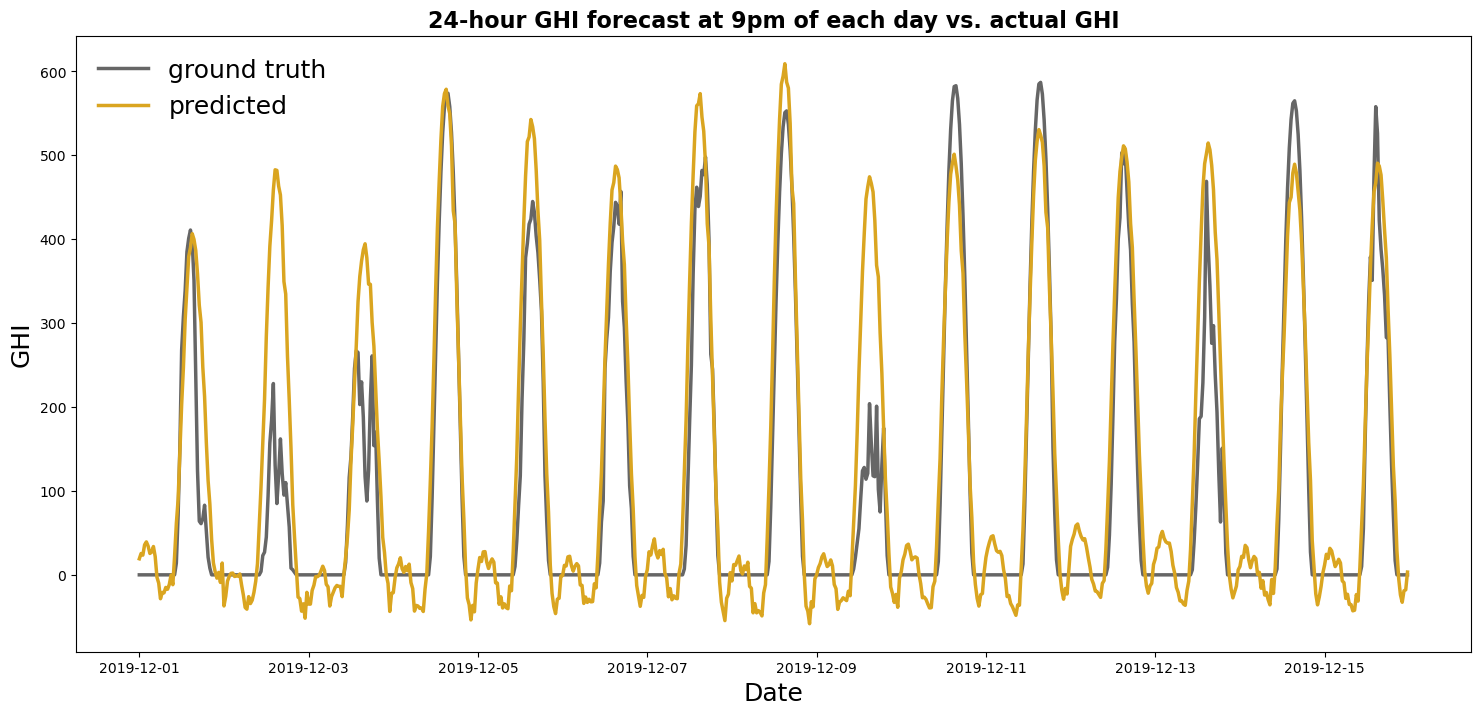

In [17]:
preds_l, test_l = [], []
x = 42
day_start, day_stop = 130, 145
for i in range(day_start, day_stop):
    test_l += list(test_y_ghi[i*48+x,:])
    preds_l += list(preds_test_ghi[i*48+x,:])

#get times
idx_start, idx_stop = (1300 + day_start)*48, (1300 + day_stop)*48
timestamps = df['datetime'][idx_start:idx_stop]
ts = pd.to_datetime(timestamps)

plt.figure(figsize=(18, 8))
plt.plot(ts,test_l, label='ground truth', color='black',  alpha=0.6, linewidth=2.5)
plt.plot(ts,preds_l, label='predicted', color='goldenrod',linewidth=2.5)
plt.xlabel('Date', fontsize=18)
plt.ylabel('GHI', fontsize=18)
plt.title('24-hour GHI forecast at 9pm of each day vs. actual GHI', fontweight='bold', fontsize=16)
plt.legend(frameon=False, fontsize=18);
plt.savefig('../figures/GHI_RNN_m1.png')

##### That looks alright! There is a strange 'second peak' around midnight, but that won't affect our model because ultimately we only care about time intervals where the sun is up.

In order to evaluate our model, we will only use points where the solar zenith angle is above 90.

Filtering these points in the y data is not trivial, because of the way the data is split up into time sequences. So we will write a function that creates a mask to easily filter the appropriate timesteps.

In [18]:
def filter_sz(sz, train_y, test_y, n_steps_in):
    """
    Given an input series of solar zenith angle, the train and test y data, and n_steps_in (number of timesteps used to forecast), 
    create boolean arrays in the same shapes as train_y and test_y, which can be used to filter out all datapoints where the sun is down
    (= solar zenith angle below 90 degrees)
    """
    
    #find all indexes where the solar zenith angle is above 90 in the OG dataframe
    sz_mask = np.where(df['Solar Zenith Angle'] < 90, 1, 0)
    train_y_mask = np.zeros(train_y.shape)
    test_y_mask = np.zeros(test_y.shape)
    n_steps_out = train_y.shape[1] #number of timesteps forecasted
    split_idx = train_y.shape[0] #index of split between train and test
    
    #now loop over each batch in train_y and make a mask
    for i in range(train_y.shape[0]):
        start = i + n_steps_in
        stop = i + n_steps_in + n_steps_out
        train_y_mask[i,:] = sz_mask[start:stop]
    for j in range(test_y.shape[0]):
        #print(j)
        start = j + n_steps_in + split_idx -1
        stop = j + n_steps_in + n_steps_out + split_idx -1
        try:
            test_y_mask[j,:] = sz_mask[start:stop]
        except:
            print(j, start, stop)
    return train_y_mask.astype(dtype=bool), test_y_mask.astype(dtype=bool)

In [19]:
train_y_mask, test_y_mask = filter_sz(df['Solar Zenith Angle'], train_y, test_y, n_steps_in)

In [20]:
train_y_filt = train_y[train_y_mask]
test_y_filt = test_y[test_y_mask]
preds_train_filt = preds_train[train_y_mask]
preds_test_filt = preds_test[test_y_mask]

Let's also filter the data/predictions in GHI units

In [21]:
test_y_ghi_filt = test_y_ghi[test_y_mask]
train_y_ghi_filt = train_y_ghi[train_y_mask]
preds_train_ghi_filt = preds_train_ghi[train_y_mask]
preds_test_ghi_filt = preds_test_ghi[test_y_mask]

R2 score on the filtered train and test data:

In [22]:
r2_score(train_y_filt, preds_train_filt), r2_score(test_y_filt, preds_test_filt)

(0.8777211108670915, 0.8382268146137385)

In [23]:
mean_squared_error(train_y_ghi_filt, preds_train_ghi_filt, squared=False), mean_squared_error(test_y_ghi_filt, preds_test_ghi_filt, squared=False)

(108.09881907422697, 120.20570845071623)

In [24]:
mean_absolute_error(train_y_ghi_filt, preds_train_ghi_filt), mean_absolute_error(test_y_ghi_filt, preds_test_ghi_filt)

(73.43358139341744, 78.5552219065133)

Note that an R2 score is not a very appropriate metric for time series (for explanation why, see eg. the responses here: https://stats.stackexchange.com/questions/101546/what-is-the-problem-with-using-r-squared-in-time-series-models). So we will focus on the RMSE and the MAE to evaluate the model performance/

## RNN with Polynomial Feature Expansion

Next, I will try a similar model with with a polynomialfeatures expansion. I will only transform the numerical features:

In [28]:
pf = PolynomialFeatures()
data_pf = pf.fit_transform(df[num_features])

# Scale
ss = StandardScaler()
stacked_sc = ss.fit_transform(data_pf)

ss_y = StandardScaler()
stacked_tot = np.hstack([stacked_sc[:,:], cloudtypes[:,:], ss_y.fit_transform(df[['GHI']].values)])

Now we can repeat the same steps as before, sequence the data and train test split

In [29]:
# choose a number of time steps 
n_steps_in, n_steps_out = 192, 48
# covert into input/output
X, y = split_sequences(stacked_tot, n_steps_in, n_steps_out)
nr_features = X.shape[2]

In [30]:
split_point = 1300 * 48
a = 1
train_X , train_y = X[:split_point, :] , y[:split_point, :]
test_X , test_y = X[split_point:, :] , y[split_point:, :]

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((62400, 192, 65), (62400, 48), (25058, 192, 65), (25058, 48))

Set up the model. Trial and error again shows that a simple network topology performs the best for this particular data

In [31]:
lstm_model_pf = Sequential()
lstm_model_pf.add(LSTM(32,return_sequences=True, input_shape=(n_steps_in, nr_features)))
lstm_model_pf.add(Dropout(0.03))
lstm_model_pf.add(LSTM(16))

lstm_model_pf.add(Dense(n_steps_out))

In [32]:
#optimizer learning rate
opt = Nadam(learning_rate=0.001)
es = EarlyStopping(patience=5)
lstm_model_pf.compile(loss='mse' , optimizer=opt , metrics=[RSquare()])

In [33]:
history_pf = lstm_model_pf.fit(train_X , train_y, batch_size=1200, epochs=90, verbose=1 ,validation_data=(test_X, test_y) ,shuffle=False, callbacks=[es])

Epoch 1/90
52/52 [==============================] - 35s 603ms/step - loss: 0.9098 - r_square: 0.1000 - val_loss: 0.7119 - val_r_square: 0.2720
Epoch 2/90
52/52 [==============================] - 21s 413ms/step - loss: 0.5633 - r_square: 0.4428 - val_loss: 0.3804 - val_r_square: 0.6110
Epoch 3/90
52/52 [==============================] - 23s 445ms/step - loss: 0.3299 - r_square: 0.6736 - val_loss: 0.2545 - val_r_square: 0.7398
Epoch 4/90
52/52 [==============================] - 24s 466ms/step - loss: 0.2412 - r_square: 0.7614 - val_loss: 0.1973 - val_r_square: 0.7982
Epoch 5/90
52/52 [==============================] - 24s 471ms/step - loss: 0.1926 - r_square: 0.8095 - val_loss: 0.1582 - val_r_square: 0.8382
Epoch 6/90
52/52 [==============================] - 23s 449ms/step - loss: 0.1586 - r_square: 0.8431 - val_loss: 0.1311 - val_r_square: 0.8659
Epoch 7/90
52/52 [==============================] - 23s 435ms/step - loss: 0.1346 - r_square: 0.8669 - val_loss: 0.1133 - val_r_square: 0.8841

In [34]:
preds_train = lstm_model_pf.predict(train_X)
preds_test = lstm_model_pf.predict(test_X)

784/784 [==============================] - 15s 18ms/step


In [35]:
test_y_ghi = ss_y.inverse_transform(test_y)
preds_test_ghi = ss_y.inverse_transform(preds_test)
train_y_ghi = ss_y.inverse_transform(train_y)
preds_train_ghi = ss_y.inverse_transform(preds_train)

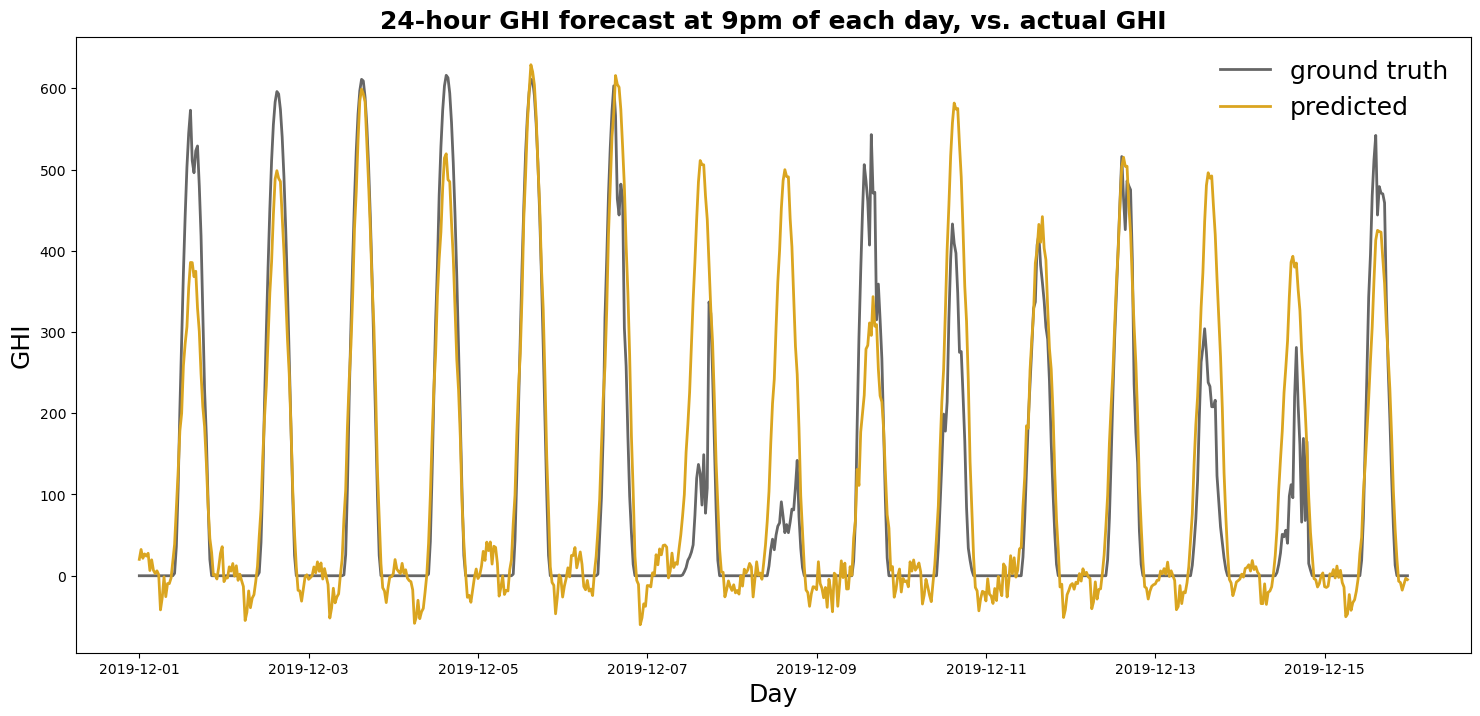

In [37]:
preds_l, test_l = [], []
x = 42 #42 timesteps after midnight, so forecast at 9pm
for i in range(115,130):
    test_l += list(test_y_ghi[i*48+x,:])
    preds_l += list(preds_test_ghi[i*48+x,:])
    
#get times
idx_start, idx_stop = (1300 + day_start)*48, (1300 + day_stop)*48
timestamps = df['datetime'][idx_start:idx_stop]
ts = pd.to_datetime(timestamps)

plt.figure(figsize=(18, 8))
plt.plot(ts,test_l, label='ground truth', color='black', alpha=0.6, linewidth=2)
plt.plot(ts,preds_l, label='predicted', color='goldenrod', linewidth=2)
plt.xlabel('Day', fontsize=18)
plt.ylabel('GHI', fontsize=18)
plt.title('24-hour GHI forecast at 9pm of each day, vs. actual GHI', fontweight='bold', fontsize=18)
plt.legend(frameon=False,fontsize=18);
plt.savefig('../figures/GHI_RNN_m2.png')

Based on the loss and r2, the feature expansion model does not seem to do significantly better. 

Let's evaluate the score for solar zenith angles under 90

In [38]:
train_y_mask, test_y_mask = filter_sz(df['Solar Zenith Angle'], train_y, test_y, n_steps_in)

In [39]:
train_y_filt = train_y[train_y_mask]
test_y_filt = test_y[test_y_mask]
preds_train_filt = preds_train[train_y_mask]
preds_test_filt = preds_test[test_y_mask]

In [40]:
test_y_ghi_filt = test_y_ghi[test_y_mask]
train_y_ghi_filt = train_y_ghi[train_y_mask]
preds_train_ghi_filt = preds_train_ghi[train_y_mask]
preds_test_ghi_filt = preds_test_ghi[test_y_mask]

In [41]:
r2_score(train_y_filt, preds_train_filt), r2_score(test_y_filt, preds_test_filt)

(0.8813012995042289, 0.8389877702844606)

In [42]:
mean_squared_error(train_y_ghi_filt, preds_train_ghi_filt, squared=False), mean_squared_error(test_y_ghi_filt, preds_test_ghi_filt, squared=False)

(106.50455707657109, 119.92266133463774)

In [43]:
mean_absolute_error(train_y_ghi_filt, preds_train_ghi_filt), mean_absolute_error(test_y_ghi_filt, preds_test_ghi_filt)

(72.08141759735479, 78.01016342152263)

So it is slightly better overall!